Which metrics can we use?
- Makespan
- Completion Time (total, avg)
- Lateness (total, avg) - how late the job is wrt due date
- Machine Utilization: $\frac{\text{Total processing time}}{\text{Total Available time}}$
- Idle Time


In [2]:
import pandas as pd
import numpy as np

# storico = pd.read_csv("data/valid/storico_Lemur.csv")
ordini = pd.read_csv("valid/storico_ordini.csv")
plan = pd.read_csv("input/storico_pianificazione.csv")

In [5]:
ordini.head()

,Cliente,n. ordine cliente,n. ordine ns,data inserimento ordine,n. ordine interno,cod articolo,descrizione,quantità,data di consegna,nr. fusi,N° MC,n° levate,gg per produrre,data arrivo materia prima,Completamento ordine,prodotto kg,consegnato kg,giacenza prodotto finito,note,Evaso
0,ATHENA,NaN,10.0,2023-05-30,190.0,4463S+ZN1,"Cr44/44f34 colorwise S+Z tpm 650 st. 3,2 (DC)",850.0,2023-08-31,256.0,1.0,3.98,19.25,NaN,2024-10-18,763.51,1124.0,"0,0",NaN,Vero
1,MICHELE LETIZIA,230094.0,18150.0,2023-02-24,105.0,X22-7806S+ZN,"Ly 78/44f72 Z tpm 900 st. 4,0 (EA)",550.0,2023-03-20,264.0,1.0,3.61,13.98,NaN,2024-10-13,497.34,554.0,NaN,NaN,Vero
2,RADICI,2003483.0,18155.0,2023-02-27,71.0,2275S+ZN-N00,"Cr22/44f34 S+Z tpm 600 st. 3,2 (DC)",2200.0,2023-05-15,264.0,1.0,9.37,46.06,NaN,2024-11-14,2757.27,2358.0,NaN,NaN,Vero
3,RADICI,2003483.0,18155.0,2023-02-27,72.0,2275S+ZN-B10A,"Cr22/44f34 S+Z tpm 600 st. 3,2 (DC)",8500.0,2023-06-30,264.0,2.0,18.10,88.97,NaN,2024-12-27,8758.16,8780.0,NaN,NaN,Vero
4,RADICI,2003483.0,18155.0,2023-02-27,73.0,2276S+ZN,"Cr22/44f30 S+Z tpm 650 st. 3,2 (DC)",3000.0,2023-05-15,256.0,2.0,6.69,38.58,NaN,2024-11-07,4296.48,3325.0,NaN,NaN,Vero


In [4]:
ordini.describe()

,n. ordine cliente,n. ordine ns,n. ordine interno,quantità,nr. fusi,N° MC,n° levate,gg per produrre,prodotto kg,consegnato kg
count,8.410000e+02,6.810000e+02,368.000000,907.000000,355.000000,357.000000,355.000000,355.000000,355.000000,907.000000
mean,1.515407e+08,2.758663e+06,212.828804,416.662624,205.977465,1.044818,3.263211,19.601944,464.357324,415.078280
std,5.268554e+08,7.036542e+07,140.721208,705.739334,98.317137,0.266495,5.596433,61.641573,814.578408,740.690282
min,4.000000e+00,1.000000e+01,1.000000,0.000000,2.000000,1.000000,0.250000,0.140000,0.000000,0.000000
25%,6.420000e+02,1.847200e+04,119.750000,60.000000,167.000000,1.000000,0.960000,1.730000,31.160000,67.500000
50%,3.042400e+04,1.867500e+04,203.000000,200.000000,256.000000,1.000000,1.420000,5.990000,226.560000,182.000000
75%,2.010230e+05,1.891800e+04,297.500000,455.000000,256.000000,1.000000,3.485000,18.240000,508.455000,418.500000
max,2.001773e+09,1.836218e+09,1831.000000,8500.000000,448.000000,4.000000,67.970000,1016.670000,8758.160000,8780.000000


In [7]:
def clean_csv(df):
    # dates to datetime
    for col in df.columns:
        if "data" in col or "inizio" or "fine" in col:
            df[col] = pd.to_datetime(df[col])

df = ordini.copy()
clean_csv(df)
df.head()

/var/folders/d8/s1xnz51d3tj_ps3_47fvlxy00000gn/T/ipykernel_56407/3531288828.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


DateParseError: Unknown datetime string format, unable to parse: ATHENA, at position 0

In [16]:
plan['data di consegna'] = pd.to_datetime(plan['data di consegna'], format='%d/%m/%Y')
plan['data inserimento produzione'] = pd.to_datetime(plan['data inserimento produzione'], format='%d/%m/%Y')
plan['fine produzione'] = pd.to_datetime(plan['fine produzione'], format='%d/%m/%Y')

In [17]:
quantita = ordini.loc[:, ['n. ordine interno', 'data inserimento ordine']
                      ].join(plan.loc[:, ['n. ordine interno', 'data inserimento produzione']
                                      ].set_index('n. ordine interno'), 
                                      on='n. ordine interno', how='left')

quantita.dropna(subset=['data inserimento produzione', 'data inserimento ordine'], inplace=True)

gap = quantita.groupby('n. ordine interno').agg({'data inserimento ordine': 'min', 'data inserimento produzione': 'max'})
gap['data inserimento ordine'] = pd.to_datetime(gap['data inserimento ordine'])
gap['data inserimento produzione'] = pd.to_datetime(gap['data inserimento produzione'])
gap['mese'] = gap['data inserimento ordine'].dt.month
gap['anno'] = gap['data inserimento ordine'].dt.year
gap['gap'] = gap['data inserimento produzione'] - gap['data inserimento ordine']
gap = gap[gap['gap'] > pd.Timedelta(0)]

In [18]:
gap_per_month = gap.groupby(['anno', 'mese']).agg({'gap': 'sum'})
gap_per_month

gap
anno mese          
2022 11    362 days
2023 2    1152 days
     3    1348 days
     4    4077 days
     5    7902 days
     6    2494 days
     7    3052 days
     8     339 days
     9     412 days
     10    386 days
     11    180 days
     12    449 days
2024 1     352 days
     2     102 days
     3     339 days
     4     272 days
     5     209 days
     6      21 days
     7      92 days
     8       7 days

<Axes: xlabel='anno,mese'>

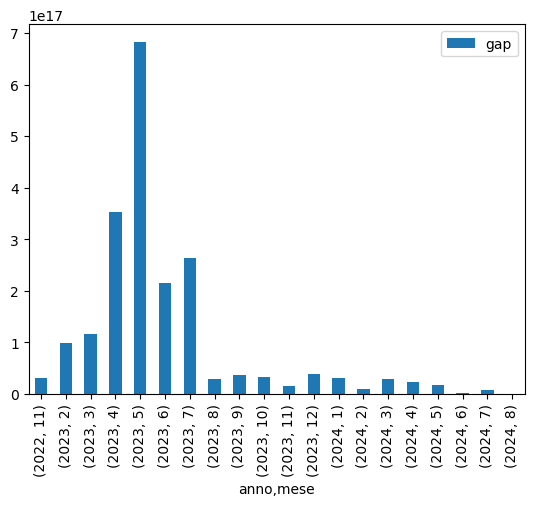

In [19]:
gap_per_month.plot(kind='bar')

In [21]:
stats = gap[gap['data inserimento ordine'] > pd.to_datetime('2024-01-01')]
stats['gap'].describe()

count                            93
mean     14 days 23:44:30.967741935
std      14 days 16:48:22.655435228
min                 1 days 00:00:00
25%                 5 days 00:00:00
50%                 9 days 00:00:00
75%                18 days 00:00:00
max                64 days 00:00:00
Name: gap, dtype: object